# RAG with Azure Document Intelligence and Azure OpenAI gpt-4o mini (image analysis)

## Architecture
<img src="https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/media/rag/azure-rag-processing.png" width=800>


## Note
Document Intelligence public preview releases provide early access to features that are in active development. Features, approaches, and processes may change, prior to General Availability (GA), based on user feedback.<br>

The public preview version of Document Intelligence client libraries default to REST API version 2024-07-31-preview.
Public preview version 2024-07-31-preview is currently only available in the following Azure regions. Note that the custom generative (document field extraction) model in AI Studio is only available in North Central US region:
- East US
- West US2
- West Europe
- North Central US

## Documentation

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-layout?view=doc-intel-4.0.0&tabs=sample-code


In [1]:
import gradio as gr
import json
import os
import sys
import openai
import pytz
import langchain
import requests
import time

from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from dotenv import load_dotenv
from datetime import datetime
from IPython.display import Image
from langchain import hub
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnableMap
from langchain.schema.runnable import RunnablePassthrough
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.vectorstores.azuresearch import AzureSearch
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from operator import itemgetter

In [2]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")
print(f"Langchain version: {langchain.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.43.0
Langchain version: 0.2.11


In [3]:
# Local timezone datetime
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
now = datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S")
print(f"Local time in {local_tz}: {now}")

Local time in Europe/Amsterdam: 06-Sep-2024 10:49:33


## 1. Settings

In [4]:
load_dotenv("azure.env")

# Azure Document Intelligence
AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
AZURE_DOCUMENT_INTELLIGENCE_KEY: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

# Azure OpenAI   
AOAI_API_ENDPOINT = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AOAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")

# Azure AI Search
AZURE_AISEARCH_ENDPOINT: str = os.getenv("AZURE_SEARCH_ENDPOINT")
AZURE_AISEARCH_KEY: str = os.getenv("AZURE_SEARCH_KEY")

In [5]:
# Azure OpenAI embeddings model
AOAI_EMBEDDINGS_MODEL: str = "text-embedding-ada-002"

# GPT model
AOAI_DEPLOYMENT_NAME: str = "gpt-4o-mini"
# API Version
AOAI_API_VERSION: str = "2024-07-01-preview"
# Type
AOAI_API_TYPE:str = "azure"

In [6]:
AOAI_DEPLOYMENT_NAME

'gpt-4o-mini'

## 2. File to analyse with Azure Document Intelligence

In [7]:
DOCS_DIR = "images"

os.makedirs(DOCS_DIR, exist_ok=True)

In [8]:
image_filename = "finance.jpg"

document_file = os.path.join(DOCS_DIR, image_filename)

In [9]:
!wget https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/finance.jpg -O $document_file

--2024-09-06 08:49:33--  https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/finance.jpg
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/finance.jpg [following]
--2024-09-06 08:49:33--  https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/finance.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150945 (147K) [image/jpeg]
Saving to: ‘images/finance.jpg’

images/finance.jpg  100%[===================>] 147.41K  --.-KB/s    in 0.003s  

2024-09-06 08:49:33 (46.8 MB/s) - ‘images/finance.jpg’ saved [150945/150945]



In [10]:
!ls $document_file -lh

-rwxrwxrwx 1 root root 148K Sep  6 08:49 images/finance.jpg


In [11]:
# Azure AI Search Index to create
base_name = os.path.basename(image_filename)
file_name, file_extension = os.path.splitext(base_name)
azure_aisearch_index_name: str = "index_img_" + str(file_name)
azure_aisearch_index_name

'index_img_finance'

### Image visualisation

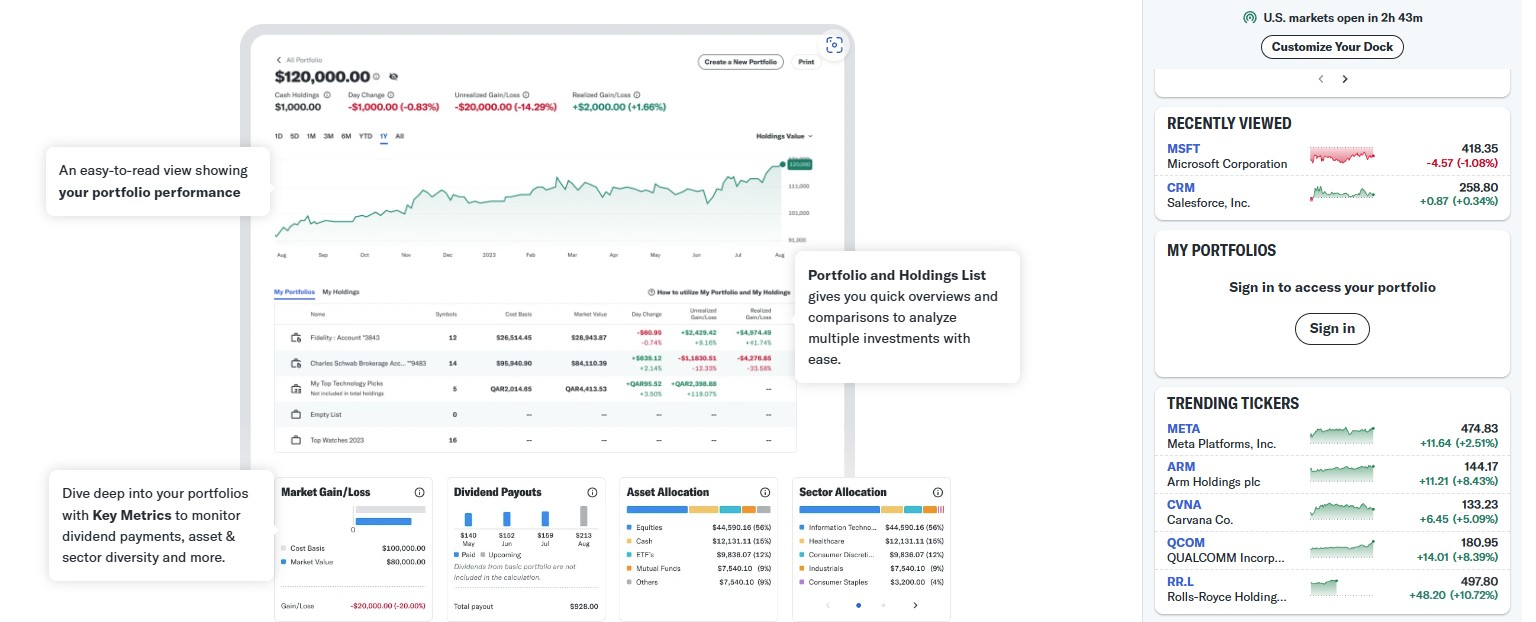

In [12]:
Image(filename=document_file) 

### Azure Document Intelligence layout example

<img src="https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/media/rag/markdown-text-output.png?view=doc-intel-4.0.0">


- **Simplified processing.** You can parse different document types, such as digital and scanned PDFs, images, office files (docx, xlsx, pptx), and HTML, with just a single API call.

- **Scalability and AI quality.** The Layout model is highly scalable in Optical Character Recognition (OCR), table extraction, and document structure analysis. It supports 309 printed and 12 handwritten languages, further ensuring high-quality results driven by AI capabilities.

- **Large language model (LLM) compatibility.** The Layout model Markdown formatted output is LLM friendly and facilitates seamless integration into your workflows. You can turn any table in a document into Markdown format and avoid extensive effort parsing the documents for greater LLM understanding.

The task of recognizing small text from large-size documents, like engineering drawings, is a challenge. Often the text is mixed with other graphical elements and has varying fonts, sizes, and orientations. Moreover, the text can be broken into separate parts or connected with other symbols. Document Intelligence now supports extracting content from these types of documents with the **ocr.highResolution** capability.

In [13]:
start = time.time()

loader = AzureAIDocumentIntelligenceLoader(
    file_path=document_file,  # File to process
    api_key=AZURE_DOCUMENT_INTELLIGENCE_KEY, # Key
    api_endpoint=AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT,  # Endpoint
    api_model="prebuilt-layout",  # Prebuilt layout of Azure Doc Intelligence
    analysis_features=["ocrHighResolution"],  # To get OCR High resolution
)

# Loading the document
print("Processing the document with Azure Document Intelligence...")
documents = loader.load()

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print("\nDone")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Processing the document with Azure Document Intelligence...

Done
Elapsed time = 0 minutes and 6 seconds


In [14]:
documents

[Document(page_content='U.S. markets open in 2h 43m Customize Your Dock < >\n\n< Al Portfolio $120,000.000 .\n\nCreate a New Portfolio\n\nPrint\n\nCash Holdings @ $1,000.00\n\nDay Change @ -$1,000.00 (-0.83%)\n\nUnrealized Gain/Loss O -$20,000.00 (-14.29%)\n\nRealand Gain/Loss @ +$2,000.00 (+1.66%)\n\nAn easy-to-read view showing your portfolio performance\n\n<figure>\n\n![](figures/0)\n\n<!-- FigureContent="1D 50 1M 3M 6M YTD TY AM Holdings Value v 130.000 111.000 101.000 Ap" -->\n\n</figure>\n\n\n| My Portfolios My Holdings | ||| How to utilize My Portfolio and My Holdings |||\n| | Bynoels | Coot Basis | Market Ville | Day Change | Unrolled Gan/Lom | Reolland |\n| - | - | - | - | - | - | - |\n| Fidelity : Account \'3843 | | $26,514.45 | $28,943.87 | -560.96 -0.74% | +52,429.42 +8.16% | +54,974.49 +41.74% |\n| :unselected: Charles Schwab Brokerage Acc ... "9483 | 14 | $95,940.90 | $84,110.39 | +5639.12 +214% | -$1.1830.51 .12.33% | -$4.276.85 -33.58% |\n| My Top Technology Picks | e |

### Semantic chunking

**Markdown** is a structured and formatted markup language and a popular input for enabling semantic chunking in RAG (Retrieval-Augmented Generation). You can use the Markdown content from the Layout model to split documents based on paragraph boundaries, create specific chunks for tables, and fine-tune your chunking strategy to improve the quality of the generated responses.

This method divides the text into chunks based on **semantic understanding**. Division boundaries are focused on sentence subject and use significant computational algorithmically complex resources. However, it has the distinct advantage of maintaining semantic consistency within each chunk. It's useful for text summarization, sentiment analysis, and document classification tasks.

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augmented-generation?view=doc-intel-4.0.0#semantic-chunking

In [15]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
    ("#####", "Header 5"),
]

text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
docs_string = documents[0].page_content
splits = text_splitter.split_text(docs_string)

print(f"Length of splits = {len(splits)}")

Length of splits = 2


## 3. Azure AI Search

In [16]:
azure_openai_embeddings = AzureOpenAIEmbeddings(
    azure_deployment=AOAI_EMBEDDINGS_MODEL,
    openai_api_version=AOAI_API_VERSION,
    azure_endpoint=AOAI_API_ENDPOINT,
    openai_api_type=AOAI_API_TYPE,
)

In [17]:
azure_openai_embeddings

AzureOpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x7f6a6c4a2c80>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x7f6a6c508790>, model='text-embedding-ada-002', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='2024-07-01-preview', openai_api_base=None, openai_api_type='azure', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=2048, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True, azure_endpoint='https://azureopenai-eastus-sr.openai.azure.com/', azure_ad_token=None, azure_ad_token_provider=None, validate_base_url=True)

In [18]:
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=AZURE_AISEARCH_ENDPOINT,
    azure_search_key=AZURE_AISEARCH_KEY,
    index_name=azure_aisearch_index_name,
    embedding_function=azure_openai_embeddings.embed_query,
)

In [19]:
start = time.time()

print(f"Adding the documents into Azure AI Search index: {azure_aisearch_index_name}")
vector_store.add_documents(documents=splits)

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print("\nDone")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Adding the documents into Azure AI Search index: index_img_finance

Done
Elapsed time = 0 minutes and 1 seconds


### Index status

In [20]:
headers = {"Content-Type": "application/json", "api-key": AZURE_AISEARCH_KEY}
params = {"api-version": "2024-07-01"}

index_status = requests.get(
    f"{AZURE_AISEARCH_ENDPOINT}/indexes/{azure_aisearch_index_name}", headers=headers, params=params
)

print(json.dumps(index_status.json(), indent=5))

{
     "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DCCE4F853F4FFD\"",
     "name": "index_img_finance",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "stored": true,
               "sortable": false,
               "facetable": false,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "dimensions": null,
               "vectorSearchProfile": null,
               "vectorEncoding": null,
               "synonymMaps": []
          },
          {
               "name": "content",
               "type": "Edm.String",
               "searchable": true,
               "filterable": false,
               "retrievable":

## 4. Azure OpenAI LLM

In [21]:
llm = AzureChatOpenAI(
    openai_api_version=AOAI_API_VERSION,
    azure_deployment=AOAI_DEPLOYMENT_NAME,
    azure_endpoint=AOAI_API_ENDPOINT,
    openai_api_type=AOAI_API_TYPE,
    temperature=0,
)

In [22]:
llm

AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f6a6c5bcd30>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f6a6c56c190>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='', azure_endpoint='https://azureopenai-eastus-sr.openai.azure.com/', deployment_name='gpt-4o-mini', openai_api_version='2024-07-01-preview', openai_api_type='azure')

## 5. Q&A

In [23]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3},
)

In [24]:
# Getting a prompt template
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [25]:
def format_docs(docs):
    """
    Format docs
    """
    return "\n\n".join(doc.page_content for doc in docs)

In [26]:
rag_chain = ({
    "context": retriever | format_docs,
    "question": RunnablePassthrough()
}
             | prompt
             | llm
             | StrOutputParser())

In [27]:
def qna(question):
    """
    QnA
    """
    print("\033[1;34m", end="")
    response = rag_chain.invoke(question)
    print(response)
    
    print("\033[1;31;32m")
    print(f"Powered by Azure AI")

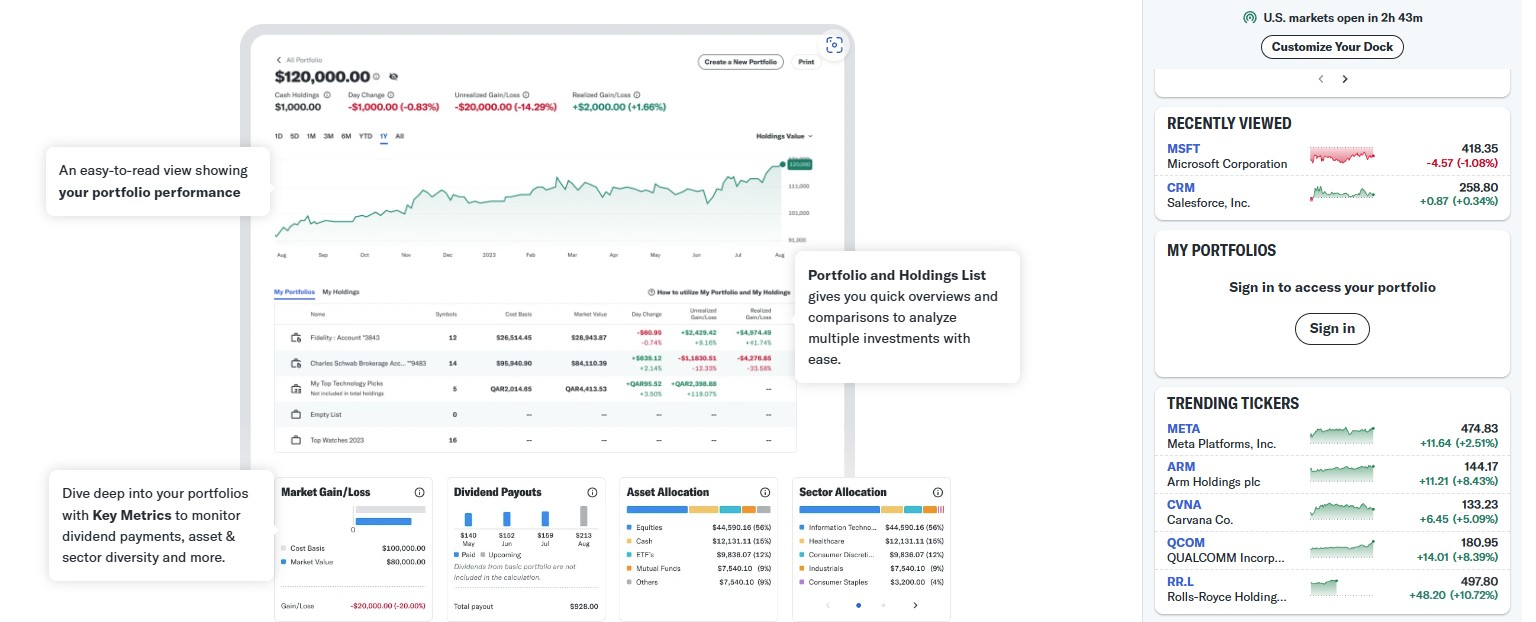

In [28]:
Image(filename=document_file) 

In [29]:
question = "What is the language of the text?"

qna(question)

The language of the text is English.

Powered by Azure AI


In [30]:
question = "Generate a summary"

qna(question)

The portfolio summary indicates a total value of $120,000, with cash holdings of $1,000. The day change shows a loss of $1,000 (-0.83%), while the unrealized loss stands at $20,000 (-14.29%). The portfolio includes various asset allocations, primarily in equities (56%) and cash (15%).

Powered by Azure AI


In [31]:
question = "What are the trending tickers?"

qna(question)

The trending tickers are META (Meta Platforms, Inc.), ARM (Arm Holdings plc), CVNA (Carvana Co.), QCOM (QUALCOMM Inc.), and RR.L (Rolls-Royce Holdings).

Powered by Azure AI


In [32]:
question = "What are the trending tickers? Print the answer in French"

qna(question)

Les tickers tendance sont : META, ARM, CVNA, QCOM, et RR.L.

Powered by Azure AI


In [33]:
question = "What is the amount of my portfolio?"

qna(question)

The amount of your portfolio is $120,000.00.

Powered by Azure AI


In [34]:
question = "What are the information about Microsoft?"

qna(question)

Microsoft Corporation (MSFT) is currently valued at $418.35, with a recent change of -4.57 (-1.08%). The context does not provide additional specific information about the company's operations or products.

Powered by Azure AI


In [35]:
question = "What are the informations about my portfolio?"

qna(question)

Your portfolio has a total value of $120,000.00, with cash holdings of $1,000.00. The day change is -$1,000.00 (-0.83%), and the unrealized loss is -$20,000.00 (-14.29%). Additionally, you have a realized gain of $2,000.00 (+1.66%).

Powered by Azure AI


In [36]:
question = "What are the informations about QUALCOMM?"

qna(question)

QUALCOMM Inc. (QCOM) is currently valued at $180.95, with a recent increase of $14.01 (8.39%). The context does not provide additional specific information about the company beyond its stock price and performance. For more detailed insights, further context would be needed.

Powered by Azure AI


In [37]:
question = "What are the informations about META?"

qna(question)

Meta Platforms, Inc. is currently valued at $474.83, with a recent increase of $11.64, representing a 2.51% rise. The context does not provide additional specific information about the company. For more detailed insights, further context would be needed.

Powered by Azure AI


In [38]:
question = "What is the sector allocation information?"

qna(question)

The sector allocation information shows the distribution of investments across different sectors. Specifically, it includes Information Technology (56%), Healthcare (16%), Consumer Discretionary (12%), Industrials (9%), and Consumer Staples (4%). This allocation helps in analyzing the diversity and risk of the portfolio.

Powered by Azure AI


## 7. Deleting the index

### Azure AI Search index status & size

In [43]:
# Construct the request URL
url = f"{AZURE_AISEARCH_ENDPOINT}/indexes/{azure_aisearch_index_name}/stats?api-version=2024-07-01"

# Set the request headers
headers = {
    "Content-Type": "application/json",
    "api-key": AZURE_AISEARCH_KEY,
}

# Make the GET request
response = requests.get(url, headers=headers)
print(f"Azure Cognitive Search index status for: {azure_aisearch_index_name}\n")

# Check the response status code
if response.status_code == 200:
    data = response.json()
    print(json.dumps(data, indent=2))

else:
    print(f"Request failed with status code: {response.status_code}")

Azure Cognitive Search index status for: index_img_finance

{
  "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#Microsoft.Azure.Search.V2024_07_01.IndexStatistics",
  "documentCount": 2,
  "storageSize": 67302,
  "vectorIndexSize": 12624
}


In [40]:
document_count = data['documentCount']
storage_size = data['storageSize'] / 1024
print(f"Number of documents = {document_count}\nTotal storage of the index = {storage_size:.2f} Kb")

Number of documents = 2
Total storage of the index = 65.72 Kb


### Deleting the Azure AI Search index

In [41]:
search_client = SearchIndexClient(
    endpoint=AZURE_AISEARCH_ENDPOINT,
    credential=AzureKeyCredential(AZURE_AISEARCH_KEY),
)

In [44]:
# Deleting the index
search_client.delete_index(azure_aisearch_index_name)